# 1. Prepare

In [ ]:
import os
import time
import PIL
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets

from tqdm.notebook import tqdm

!pip install einops
from einops import rearrange
from einops.layers.torch import Rearrange

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# root_path = './drive/MyDrive/cityscapes_data'
root_path = './drive/MyDrive/CS470_IAI_2022Fall-main/x_prj/cityscapes_data'
data_dir = './drive/MyDrive/CS470_IAI_2022Fall-main/x_prj/cityscapes_data'
train_dir = os.path.join(data_dir, "train")
train_fns = os.listdir(train_dir)
val_dir = os.path.join(data_dir, "val")
val_fns = os.listdir(val_dir)

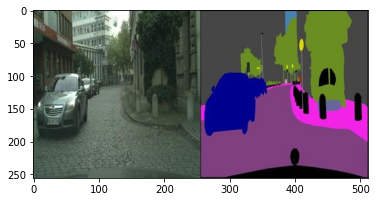

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
plt.show()

In [ ]:
color_array = np.array([(0, 0, 0), (0, 0, 70), (0, 0, 90), (0, 0, 110), (0, 0, 142), (0, 0, 230), (0, 60, 100), (0, 80, 100), (70, 70, 70), (70, 130, 180), (81, 0, 81), (102, 102, 156), (107, 142, 35), (111, 74, 0), (119, 11, 32), (128, 64, 128), (150, 100, 100), (150, 120, 90), (152, 251, 152), (153, 153, 153), (180, 165, 180), (190, 153, 153), (220, 20, 60), (220, 220, 0), (230, 150, 140), (244, 35, 232), (250, 170, 30), (250, 170, 160), (255, 0, 0)])
num_classes = 29
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=29)

In [ ]:
# # 이전에 샘플이미지에서 볼 수 있듯이, original image와 labeled image가 연결되어 있는데 이를 분리해줍니다.
# def split_image(image) :
#    image = np.array(image)
   
#    # 이미지의 크기가 256 x 512 였는데 이를 original image와 labeled image로 분리하기 위해 리스트로 슬라이싱 합니다.
#    # 그리고 분리된 이미지를 각각 cityscape(= original image)와 label(= labeled image)에 저장합니다.
#    cityscape, label = image[:, :256, :], image[:, 256:, :]
#    return cityscape, label


# # 바로 이전 코드에서 정의한 split_image() 함수를 이용하여 sample_image를 분리한 후, cityscape과 label에 각각 저장합니다.
# cityscape, label = split_image(sample_image)

# label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
# fig, axes = plt.subplots(1, 3, figsize = (15, 5))
# axes[0].imshow(cityscape)
# axes[1].imshow(label)
# axes[2].imshow(label_class)

# plt.show()

In [ ]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model
    
  def __len__(self) :
    return len(self.image_fns)
    
  def __getitem__(self, index) :
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp)
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class
    
  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label
    
  def transform(self, image) :
    transform_ops = transforms.Compose([
      			        transforms.ToTensor(),
                    transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [ ]:
# dataset = CityscapeDataset(train_dir, label_model)
# print(len(dataset))

# cityscape, label_class = dataset[0]
# print(cityscape.shape)
# print(label_class.shape)

# 2. Model

## 2.0

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

## 2.1. Layers

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, rate=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               dilation=rate, padding=rate, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.rate = rate

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, nInputChannels, block, layers, os=16, pretrained=False):
        self.inplanes = 64
        super(ResNet, self).__init__()
        if os == 16:
            strides = [1, 2, 2, 1]
            rates = [1, 1, 1, 2]
            blocks = [1, 2, 4]
        elif os == 8:
            strides = [1, 2, 1, 1]
            rates = [1, 1, 2, 2]
            blocks = [1, 2, 1]
        else:
            raise NotImplementedError

        # Modules
        self.conv1 = nn.Conv2d(nInputChannels, 64, kernel_size=7, stride=2, padding=3,
                                bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], rate=rates[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], rate=rates[1])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], rate=rates[2])
        self.layer4 = self._make_MG_unit(block, 512, blocks=blocks, stride=strides[3], rate=rates[3])

        self._init_weight()

        if pretrained:
          print("load_pretrained_model disabled")
        #     self._load_pretrained_model()

    def _make_layer(self, block, planes, blocks, stride=1, rate=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, rate, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_MG_unit(self, block, planes, blocks=[1,2,4], stride=1, rate=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, rate=blocks[0]*rate, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, len(blocks)):
            layers.append(block(self.inplanes, planes, stride=1, rate=blocks[i]*rate))

        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        low_level_feat = x
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('https://download.pytorch.org/models/resnet101-5d3b4d8f.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

def ResNet101(nInputChannels=3, os=16, pretrained=False):
    model = ResNet(nInputChannels, Bottleneck, [3, 4, 23, 3], os, pretrained=pretrained)
    return model

In [ ]:
class ASPP_module(nn.Module):
    def __init__(self, inplanes, planes, rate):
        super(ASPP_module, self).__init__()
        if rate == 1:
            kernel_size = 1
            padding = 0
        else:
            kernel_size = 3
            padding = rate
        self.atrous_convolution = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=rate, bias=False)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_convolution(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

## 2.2. DeepLabV3+

In [ ]:
class DeepLabv3_plus(nn.Module):
    def __init__(self, nInputChannels=3, n_classes=21, os=16, pretrained=False, _print=True):
        if _print:
            print("Constructing DeepLabv3+ model...")
            print("Number of classes: {}".format(n_classes))
            print("Output stride: {}".format(os))
            print("Number of Input Channels: {}".format(nInputChannels))
        super(DeepLabv3_plus, self).__init__()

        # Atrous Conv
        self.resnet_features = ResNet101(nInputChannels, os, pretrained=pretrained)

        # ASPP
        if os == 16:
            rates = [1, 6, 12, 18]
        elif os == 8:
            rates = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = ASPP_module(2048, 256, rate=rates[0])
        self.aspp2 = ASPP_module(2048, 256, rate=rates[1])
        self.aspp3 = ASPP_module(2048, 256, rate=rates[2])
        self.aspp4 = ASPP_module(2048, 256, rate=rates[3])

        self.relu = nn.ReLU()

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(2048, 256, 1, stride=1, bias=False),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU())

        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        # adopt [1x1, 48] for channel reduction.
        self.conv2 = nn.Conv2d(256, 48, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(48)

        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, n_classes, kernel_size=1, stride=1))

    def forward(self, input):
        x, low_level_features = self.resnet_features(input)
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.upsample(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = F.upsample(x, size=(int(math.ceil(input.size()[-2]/4)),
                                int(math.ceil(input.size()[-1]/4))), mode='bilinear', align_corners=True)

        low_level_features = self.conv2(low_level_features)
        low_level_features = self.bn2(low_level_features)
        low_level_features = self.relu(low_level_features)


        x = torch.cat((x, low_level_features), dim=1)
        x = self.last_conv(x)
        x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def get_1x_lr_params(model):
    """
    This generator returns all the parameters of the net except for
    the last classification layer. Note that for each batchnorm layer,
    requires_grad is set to False in deeplab_resnet.py, therefore this function does not return
    any batchnorm parameter
    """
    b = [model.resnet_features]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k


def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the last layer of the net,
    which does the classification of pixel into classes
    """
    b = [model.aspp1, model.aspp2, model.aspp3, model.aspp4, model.conv1, model.conv2, model.last_conv]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k


# if __name__ == "__main__":
#     model = DeepLabv3_plus(nInputChannels=3, n_classes=21, os=16, pretrained=True, _print=True)
#     model.eval()
#     image = torch.randn(1, 3, 512, 512)
#     with torch.no_grad():
#         output = model.forward(image)
#     print(output.size())
model = DeepLabv3_plus(nInputChannels=3, n_classes=21, os=16, pretrained=False, _print=True)
model.eval()
image = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    output = model.forward(image)
print(output.size())

Constructing DeepLabv3+ model...
Number of classes: 21
Output stride: 16
Number of Input Channels: 3
torch.Size([1, 21, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


# 3. Train

In [ ]:
model = DeepLabv3_plus(
    nInputChannels=3, 
    n_classes=29, 
    os=16, 
    pretrained=False, 
    _print=True)
model.to(device)

Constructing DeepLabv3+ model...
Number of classes: 29
Output stride: 16
Number of Input Channels: 3


DeepLabv3_plus(
  (resnet_features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

In [ ]:
batch_size = 32

epochs = 10
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)


step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)) :
  epoch_loss = 0
  
  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    print('Y: ', Y.shape)
    print('Y_pred: ', Y_pred.shape)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([31, 256, 256])
Y_pred:  torch.Size([31, 29, 256, 256])


  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([31, 256, 256])
Y_pred:  torch.Size([31, 29, 256, 256])


  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([31, 256, 256])
Y_pred:  torch.Size([31, 29, 256, 256])


  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([31, 256, 256])
Y_pred:  torch.Size([31, 29, 256, 256])


  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([31, 256, 256])
Y_pred:  torch.Size([31, 29, 256, 256])


  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([31, 256, 256])
Y_pred:  torch.Size([31, 29, 256, 256])


  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([31, 256, 256])
Y_pred:  torch.Size([31, 29, 256, 256])


  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([31, 256, 256])
Y_pred:  torch.Size([31, 29, 256, 256])


  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([31, 256, 256])
Y_pred:  torch.Size([31, 29, 256, 256])


  0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([32, 256, 256])
Y_pred:  torch.Size([32, 29, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Y:  torch.Size([31, 256, 256])
Y_pred:  torch.Size([31, 29, 256, 256])


In [ ]:
print(len(epoch_losses))
print(epoch_losses)

10
[1.2728970364857746, 0.9862089086604374, 0.9268083687751524, 0.8903147808967098, 0.8496150291094215, 0.8197290974278604, 0.7875276868061353, 0.75981379132117, 0.7401328535490138, 0.7201590563661309]


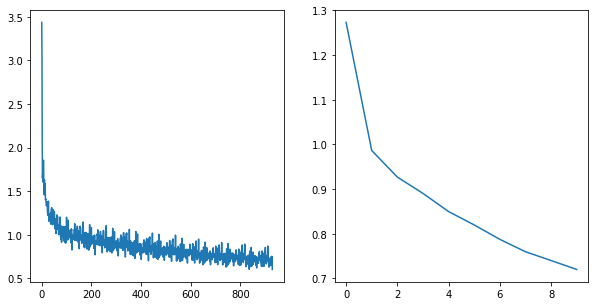

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

plt.show()

In [ ]:
model_name = "DeepLabV3Plus"
model_path = root_path + model_name
torch.save(model.state_dict(), model_path)

In [ ]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 29, 256, 256])
torch.Size([8, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

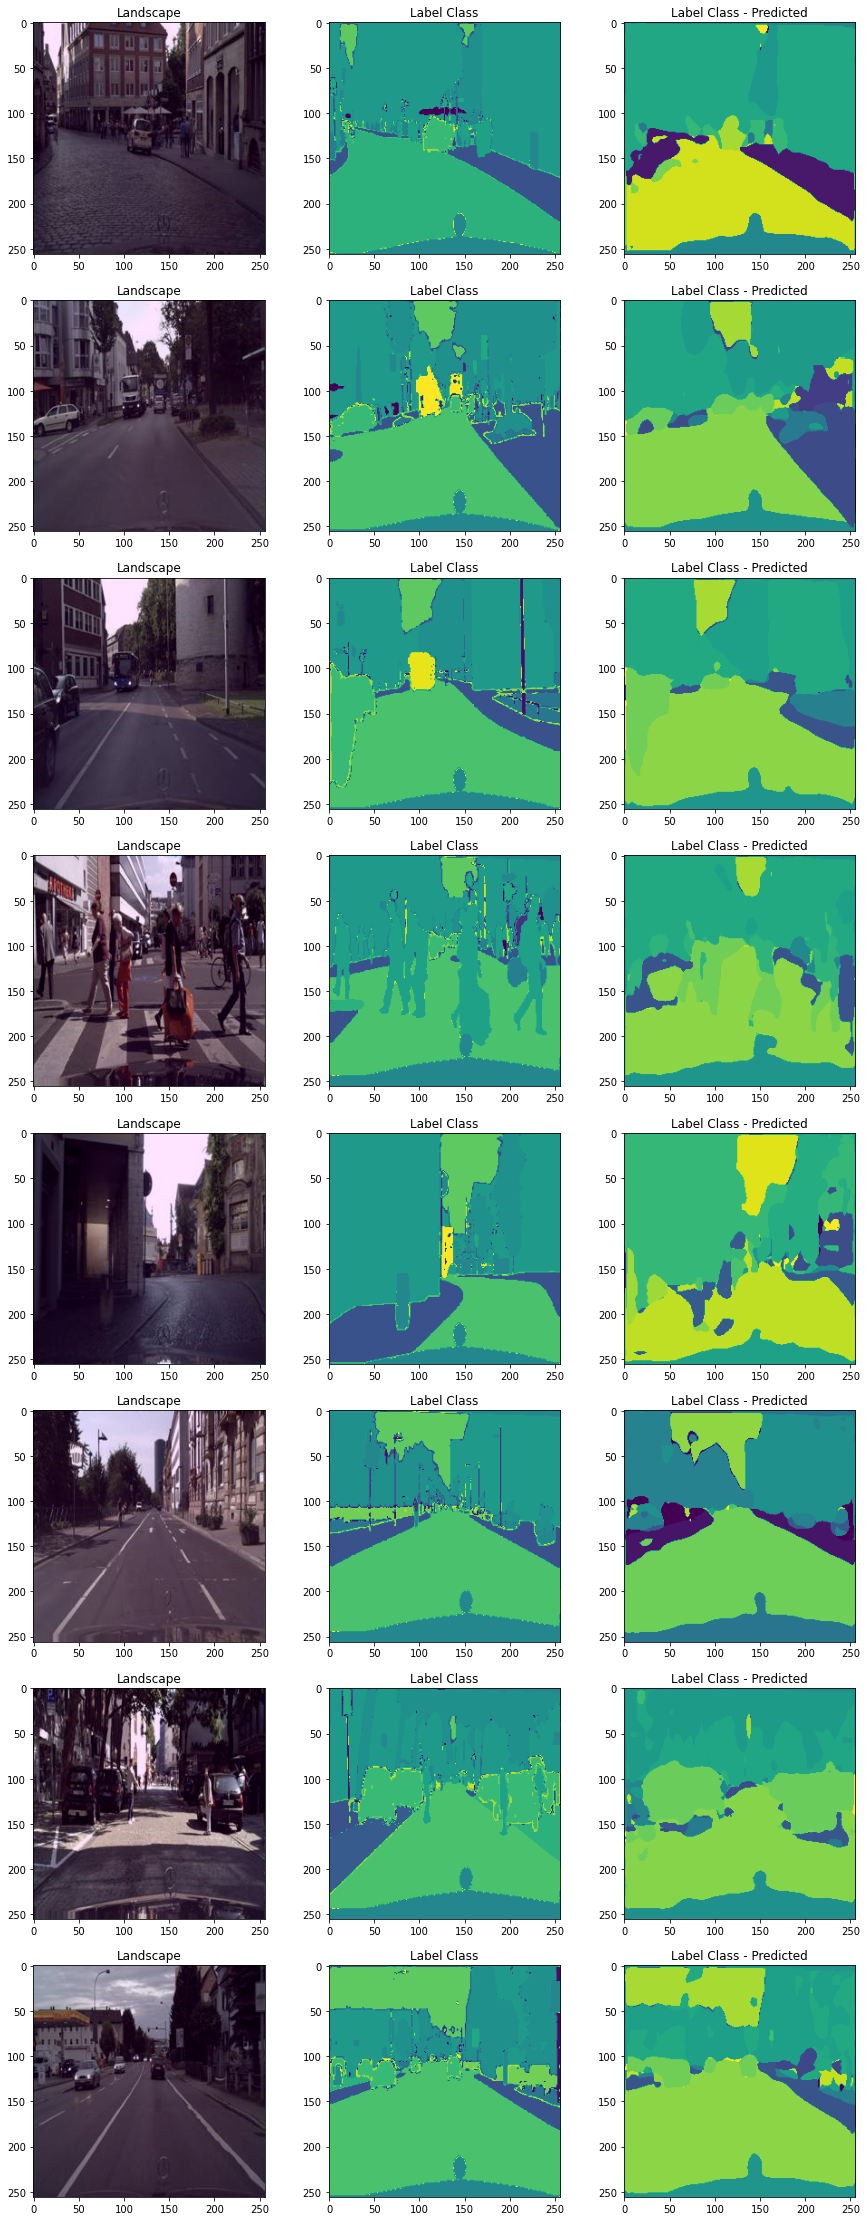

In [ ]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

In [ ]:
print(sum(iou_scores) / len(iou_scores))

0.9975185394287109


In [ ]:
# import socket
# import timeit
# from datetime import datetime
# import os
# import glob
# from collections import OrderedDict
# import numpy as np

# # PyTorch includes
# import torch
# from torch.autograd import Variable
# import torch.optim as optim
# from torchvision import transforms
# from torch.utils.data import DataLoader
# from torchvision.utils import make_grid

# # Tensorboard include
# from tensorboardX import SummaryWriter

# # Custom includes
# from dataloaders import cityscapes
# from dataloaders import utils
# from networks import deeplab_xception, deeplab_resnet
# from dataloaders import custom_transforms as tr

# gpu_id = 0
# print('Using GPU: {} '.format(gpu_id))
# # Setting parameters
# nEpochs = 100  # Number of epochs for training

# p = OrderedDict()  # Parameters to include in report
# p['trainBatch'] = 4  # Training batch size
# testBatch = 4  # Testing batch size
# useTest = True  # See evolution of the test set when training
# nValInterval = 5  # Run on test set every nTestInterval epochs
# snapshot = 10  # Store a model every snapshot epochs
# p['nAveGrad'] = 1  # Average the gradient of several iterations
# p['lr'] = 1e-7  # Learning rate
# p['wd'] = 5e-4  # Weight decay
# p['momentum'] = 0.9  # Momentum
# p['epoch_size'] = 10  # How many epochs to change learning rate
# backbone = 'xception' # Use xception or resnet as feature extractor,

# # Network definition
# if backbone == 'xception':
#     raise NotImplementedError
#     # net = deeplab_xception.DeepLabv3_plus(nInputChannels=3, n_classes=19, os=16, pretrained=True)
# elif backbone == 'resnet':
#     net = DeepLabv3_plus(nInputChannels=3, n_classes=19, os=16, pretrained=True)
# else:
#     raise NotImplementedError
# modelName = 'deeplabv3plus-' + backbone + '-cityscapes'
# criterion = utils.cross_entropy2d

# print("Training deeplabv3+ from scratch...")

# # log_dir save_dir writer

# # Use the following optimizer
# optimizer = optim.SGD(net.parameters(), lr=p['lr'], momentum=p['momentum'], weight_decay=p['wd'])
# p['optimizer'] = str(optimizer)

# composed_transforms_tr = transforms.Compose([
#     tr.RandomHorizontalFlip(),
#     tr.RandomScale((0.5, 0.75)),
#     tr.RandomCrop((512, 1024)),
#     tr.RandomRotate(5),
#     tr.Normalize_cityscapes(mean=(72.39, 82.91, 73.16)),
#     tr.ToTensor()])

# composed_transforms_ts = transforms.Compose([
#     tr.RandomHorizontalFlip(),
#     tr.Scale((819, 1638)),
#     tr.CenterCrop((512, 1024)),
#     tr.Normalize_cityscapes(mean=(72.39, 82.91, 73.16)),
#     tr.ToTensor()])

# cityscapes_train = cityscapes.CityscapesSegmentation(split='train', transform=composed_transforms_tr)
# cityscapes_val = cityscapes.CityscapesSegmentation(split='val', transform=composed_transforms_ts)
# cityscapes_test = cityscapes.CityscapesSegmentation(split='test', transform=composed_transforms_ts)

# trainloader = DataLoader(cityscapes_train, batch_size=p['trainBatch'], shuffle=True, num_workers=0)
# valloader = DataLoader(cityscapes_val, batch_size=testBatch, shuffle=True, num_workers=0)
# testloader = DataLoader(cityscapes_test, batch_size=testBatch, shuffle=False, num_workers=0)

# num_img_tr = len(trainloader)
# num_img_vl = len(valloader)
# num_img_ts = len(testloader)
# running_loss_tr = 0.0
# running_loss_vl = 0.0
# running_loss_ts = 0.0
# previous_miou = -1.0
# aveGrad = 0
# global_step = 0
# print("Training Network")

# # Main Training and Testing Loop
# for epoch in range(0, nEpochs):
#     start_time = timeit.default_timer()

#     if epoch % p['epoch_size'] == p['epoch_size'] - 1:
#         lr_ = utils.lr_poly(p['lr'], epoch, nEpochs, 0.9)
#         print('(poly lr policy) learning rate: ', lr_)
#         optimizer = optim.SGD(net.parameters(), lr=lr_, momentum=p['momentum'], weight_decay=p['wd'])

#     net.train()
#     for ii, sample_batched in enumerate(trainloader):

#         inputs, labels = sample_batched['image'], sample_batched['label']
#         # Forward-Backward of the mini-batch
#         inputs, labels = Variable(inputs, requires_grad=True), Variable(labels)
#         global_step += inputs.data.shape[0]

#         if gpu_id >= 0:
#             inputs, labels = inputs.cuda(), labels.cuda()

#         outputs = net.forward(inputs)

#         loss = criterion(outputs, labels, size_average=False, batch_average=True)
#         running_loss_tr += loss.item()

#         # Print stuff
#         if ii % num_img_tr == (num_img_tr - 1):
#             running_loss_tr = running_loss_tr / num_img_tr
#             print('[Epoch: %d, numImages: %5d]' % (epoch, ii * p['trainBatch'] + inputs.data.shape[0]))
#             print('Loss: %f' % running_loss_tr)
#             running_loss_tr = 0
#             stop_time = timeit.default_timer()
#             print("Execution time: " + str(stop_time - start_time) + "\n")

#         # Backward the averaged gradient
#         loss /= p['nAveGrad']
#         loss.backward()
#         aveGrad += 1

#         # Update the weights once in p['nAveGrad'] forward passes
#         if aveGrad % p['nAveGrad'] == 0:
#             optimizer.step()
#             optimizer.zero_grad()
#             aveGrad = 0

#         # Show 10 * 3 images results each epoch
#         if ii % (num_img_tr // 10) == 0:
#             grid_image = make_grid(inputs[:3].clone().cpu().data, 3, normalize=True)
#             grid_image = make_grid(
#                 utils.decode_seg_map_sequence(torch.max(outputs[:3], 1)[1].detach().cpu().numpy(), 'cityscapes'), 3,
#                 normalize=False,
#                 range=(0, 255))
#             grid_image = make_grid(
#                 utils.decode_seg_map_sequence(torch.squeeze(labels[:3], 1).detach().cpu().numpy(), 'cityscapes'), 3,
#                 normalize=False, range=(0, 255))\

#     # One testing epoch
#     if epoch % nValInterval == (nValInterval - 1):
#         total_miou = 0.0
#         net.eval()
#         for ii, sample_batched in enumerate(valloader):
#             inputs, labels = sample_batched['image'], sample_batched['label']

#             # Forward pass of the mini-batch
#             inputs, labels = Variable(inputs, requires_grad=True), Variable(labels)
#             if gpu_id >= 0:
#                 inputs, labels = inputs.cuda(), labels.cuda()

#             with torch.no_grad():
#                 outputs = net.forward(inputs)

#             predictions = torch.max(outputs, 1)[1]

#             loss = criterion(outputs, labels, size_average=False, batch_average=True)
#             running_loss_vl += loss.item()
#             total_miou += utils.get_iou(predictions, labels, 19)

#             # Print stuff
#             if ii % num_img_vl == num_img_vl - 1:
#                 miou = total_miou / (ii * testBatch + inputs.data.shape[0])
#                 running_loss_vl = running_loss_vl / num_img_vl

#                 print('Validation:')
#                 print('[Epoch: %d, numImages: %5d]' % (epoch, ii * testBatch + inputs.data.shape[0]))
#                 print('Loss: %f' % running_loss_vl)
#                 print('MIoU: %f\n' % miou)
#                 running_loss_vl = 0

#     # Save the model
#     if (epoch % snapshot) == snapshot - 1 and miou > previous_miou:
#         previous_miou = miou


# # if useTest:
# #     total_iou = 0.0
# #     net.eval()
# #     for ii, sample_batched in enumerate(testloader):
# #         inputs, labels = sample_batched['image'], sample_batched['label']

# #         # Forward pass of the mini-batch
# #         inputs, labels = Variable(inputs, requires_grad=True), Variable(labels)
# #         if gpu_id >= 0:
# #             inputs, labels = inputs.cuda(), labels.cuda()

# #         with torch.no_grad():
# #             outputs = net.forward(inputs)

# #         predictions = torch.max(outputs, 1)[1]

# #         loss = criterion(outputs, labels, size_average=False, batch_average=True)
# #         running_loss_ts += loss.item()

# #         total_iou += utils.get_iou(predictions, labels, 19)

# #         # Print stuff
# #         if ii % num_img_ts == num_img_ts - 1:
# #             miou = total_iou / (ii * testBatch + inputs.data.shape[0])
# #             running_loss_ts = running_loss_ts / num_img_ts

# #             print('Test:')
# #             print('Loss: %f' % running_loss_ts)
# #             print('MIoU: %f\n' % miou)
# #             running_loss_ts = 0